In [1]:
from geosnap.analyze import compute_travel_cost_adjlist, isochrone, isochrones # a singular and a plural
from geosnap.io import get_acs
from geosnap import DataStore

/Users/knaaptime/Dropbox/projects/geosnap/geosnap/_data.py:66: UserWarning: The geosnap data storage class is provided for convenience only. The geosnap developers make no promises regarding data quality, consistency, or availability, nor are they responsible for any use/misuse of the data. The end-user is responsible for any and all analyses or applications created with the package.
  warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
import pandana as pdna
import geopandas as gpd

In [3]:
datasets = DataStore()

/Users/knaaptime/Dropbox/projects/geosnap/geosnap/_data.py:66: UserWarning: The geosnap data storage class is provided for convenience only. The geosnap developers make no promises regarding data quality, consistency, or availability, nor are they responsible for any use/misuse of the data. The end-user is responsible for any and all analyses or applications created with the package.
  warn(


To generate a routable network, use [pandana]() or [urbanaccess](). Alternatively, you can download one of the metropolitan-scale pedestrian networks for the U.S. from geosnap's [quilt bucket](https://open.quiltdata.com/b/spatial-ucr/tree/osm/metro_networks_8k/). The files are named for each CBSA fips code and extend 8km beyond the metro region's borders to help mitigate edge effects. Here, we'll use the quilt version from the San Diego region.

## San Clemente

In [4]:
sd_network = pdna.Network.from_hdf5("../../geosnap_data/metro_networks_8k/41740.h5")

Generating contraction hierarchies with 10 threads.
Setting CH node vector of size 332554
Setting CH edge vector of size 522484
Range graph removed 143094 edges of 1044968
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


To generate a travel isochrone, we have to specify an origin node on the network. For demonstration purposes, we can randomly select an origin from the network's `nodes_df` dataframe (or choose a pre-selected example). To get the nodes for a specific set of origins, you can use pandana's [`get_node_ids`](http://udst.github.io/pandana/network.html#pandana.network.Network.get_node_ids) function

In [5]:
example_origin = 1985327805

In [6]:
%%time
iso = isochrone(example_origin, sd_network, threshold=1600 ) # network is expressed in meters

/Users/knaaptime/Dropbox/projects/geosnap/geosnap/analyze/network.py:42: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  origins.centroid.x, origins.centroid.y
/Users/knaaptime/Dropbox/projects/geosnap/geosnap/analyze/network.py:42: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  origins.centroid.x, origins.centroid.y
/Users/knaaptime/Dropbox/projects/geosnap/geosnap/analyze/network.py:45: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  destinations.centroid.x, destinations.centroid.y
/Users/knaaptime/Dropbox/projects/geosnap/geosnap/analyze/network.py:45: UserWarning: Geometr

  0%|          | 0/1 [00:00<?, ?it/s]

CPU times: user 8.41 s, sys: 912 ms, total: 9.33 s
Wall time: 5.83 s


We can also look at how the isochrone or bespoke neighborhood changes size and shape as we consider alternative travel thresholds. Because of the underlying network configuration, changing the threshold often results in some areas of the "neighborhood" changing more than others

In [7]:
# convert the node into a Point and buffer it 1600m

example_point = gpd.GeoDataFrame(sd_network.nodes_df.loc[example_origin]).T
example_point.crs=4326
planar_iso = example_point.to_crs(example_point.estimate_utm_crs()).buffer(1600)

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('paper')
import proplot as pplt
import contextily as ctx

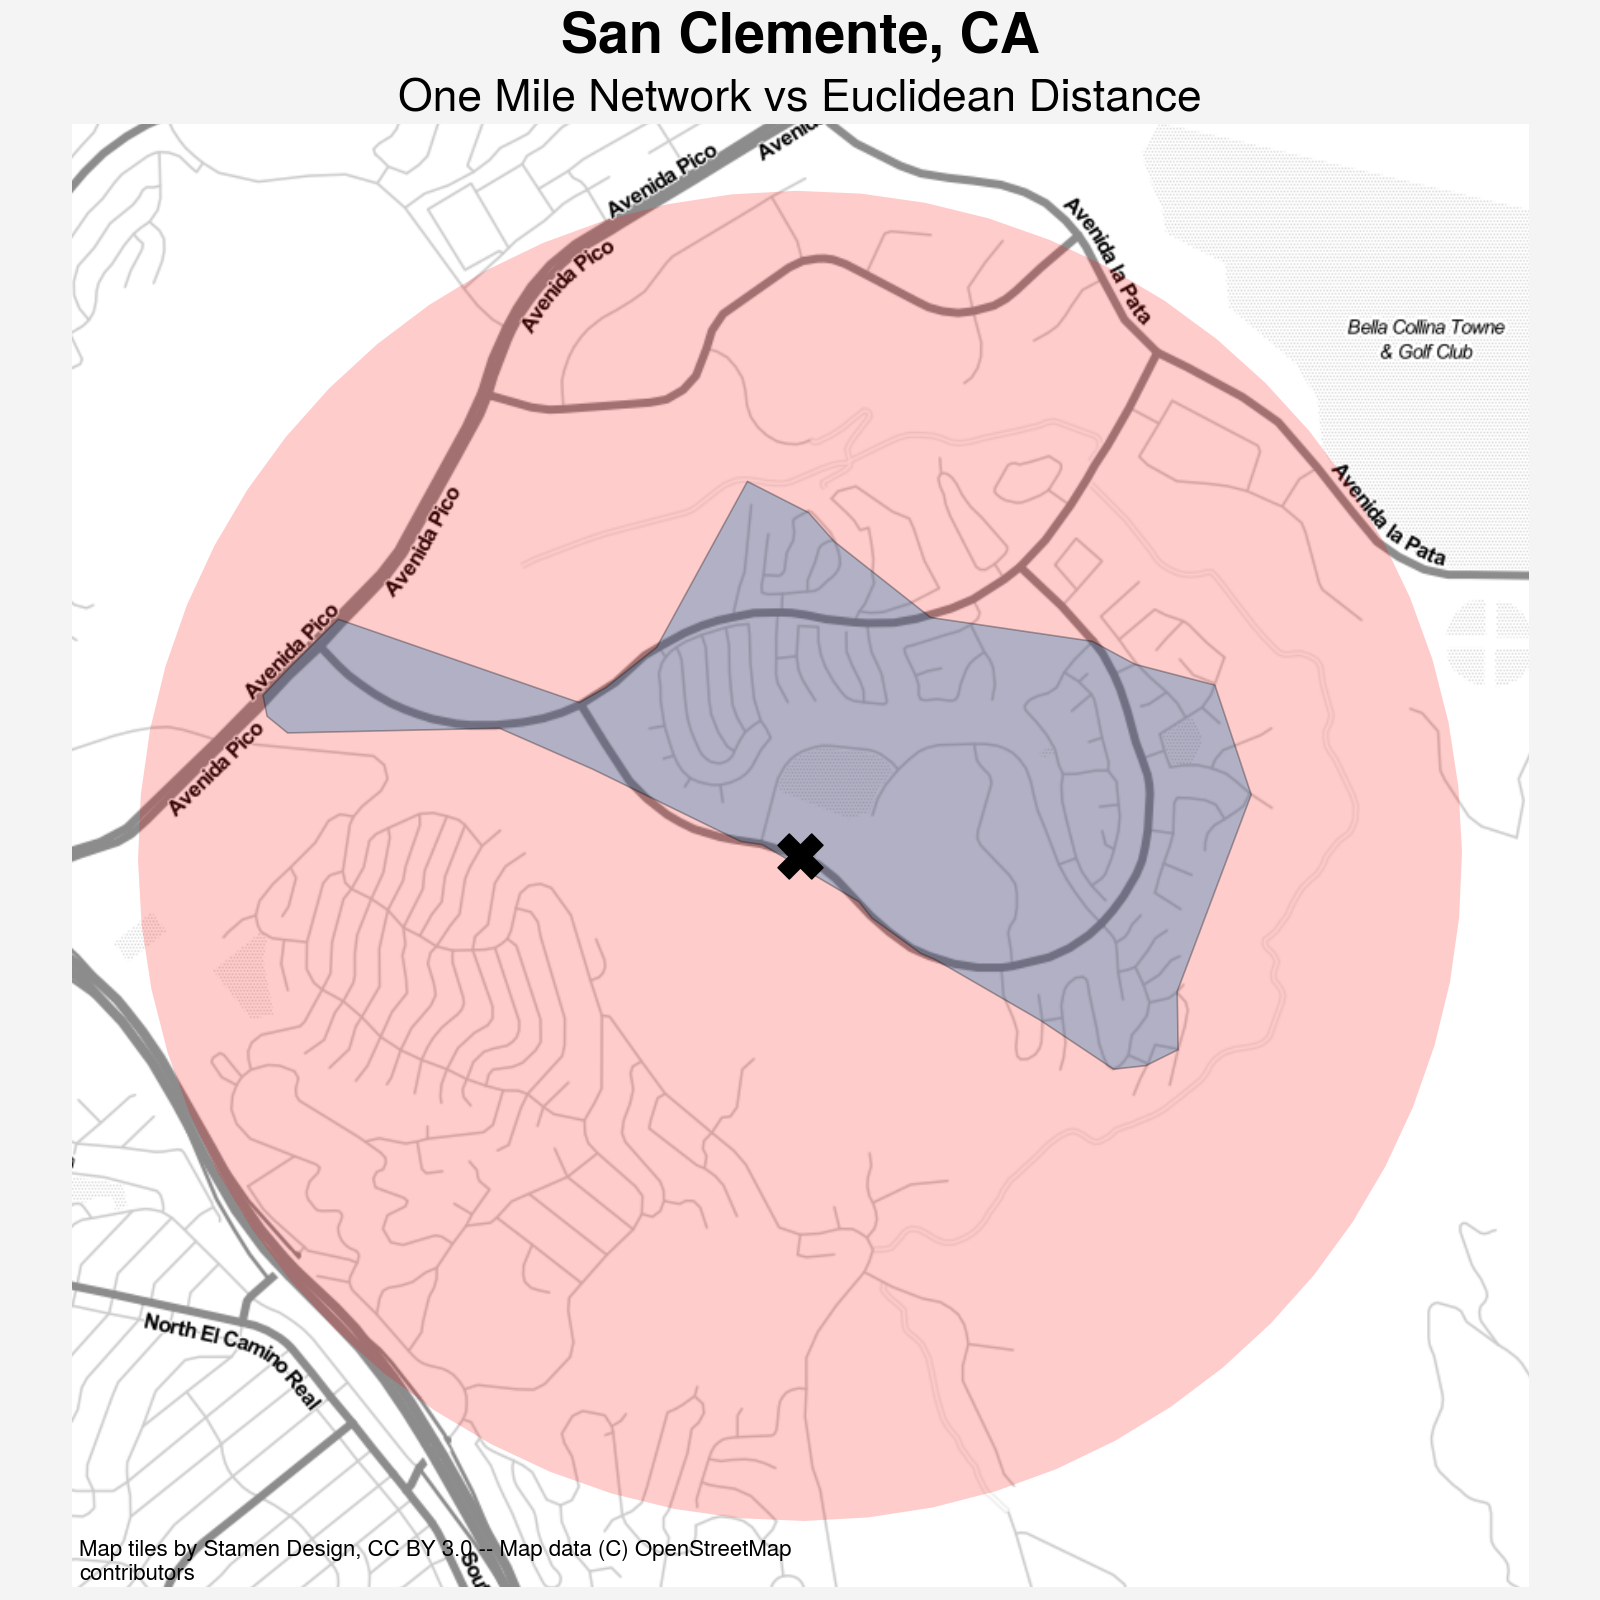

In [25]:
f, ax = pplt.subplots(figsize=(8,8))

planar_iso.to_crs(3857).plot(ax=ax, color='red', alpha=0.2)
iso.to_crs(3857).plot(ax=ax, alpha=0.3, ec='black', )
example_point.to_crs(3857).plot(ax=ax, color='black', marker='X', markersize=260)
ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite)
ax.axis('off')
ax.set_title('One Mile Network vs Euclidean Distance', fontsize=16)
plt.suptitle('San Clemente, CA', fontsize=20)
plt.savefig("../paper/figures/network_distance.png", dpi=200)

In [24]:
(planar_iso.to_crs(planar_iso.estimate_utm_crs()).area.values[0] - iso.to_crs(iso.estimate_utm_crs()).area.values[0]) / planar_iso.to_crs(planar_iso.estimate_utm_crs()).area.values[0]

0.8354413245295005

In [23]:
planar_iso.to_crs(planar_iso.estimate_utm_crs()).area.values[0]

8029564.135797618

In [38]:
iso.to_crs(iso.estimate_utm_crs()).area.values[0]

1321334.438792282

In [25]:
iso.to_crs(iso.estimate_utm_crs()).area.values[0] / planar_iso.to_crs(planar_iso.estimate_utm_crs()).area.values[0]

0.16455867547049952

In [29]:
iso.to_crs(iso.estimate_utm_crs()).area.values[0] * 3.86102e-7 #sqmi

0.5101698694865777

In [30]:
planar_iso.to_crs(planar_iso.estimate_utm_crs()).area.values[0] * 3.86102e-7

3.100230771959732

duh.. this should be $\pi$ times one mile squared

## Chicago

In [10]:
chi_network = pdna.Network.from_hdf5("../../geosnap_data/metro_networks_8k/16980.h5")

Generating contraction hierarchies with 10 threads.
Setting CH node vector of size 749093
Setting CH edge vector of size 1235156
Range graph removed 311884 edges of 2470312
. 10% . 20% . 30% . 40% . 50% . 60% . 70% . 80% . 90% . 100%


In [40]:
from random import sample

In [53]:
random_origin = sample(chi_network.nodes_df.index.unique().tolist(),1)[0]

In [54]:
random_origin

305901652

In [11]:
chi_origin = 305901652

In [12]:
chi_iso = isochrone(chi_origin, chi_network, threshold=1600 ) # network is expressed in meters

/Users/knaaptime/Dropbox/projects/geosnap/geosnap/analyze/network.py:42: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  origins.centroid.x, origins.centroid.y
/Users/knaaptime/Dropbox/projects/geosnap/geosnap/analyze/network.py:42: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  origins.centroid.x, origins.centroid.y
/Users/knaaptime/Dropbox/projects/geosnap/geosnap/analyze/network.py:45: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  destinations.centroid.x, destinations.centroid.y
/Users/knaaptime/Dropbox/projects/geosnap/geosnap/analyze/network.py:45: UserWarning: Geometr

  0%|          | 0/1 [00:00<?, ?it/s]

In [13]:
chi_point = gpd.GeoDataFrame(chi_network.nodes_df.loc[chi_origin]).T
chi_point.crs=4326
chi_planar_iso = chi_point.to_crs(chi_point.estimate_utm_crs()).buffer(1600)

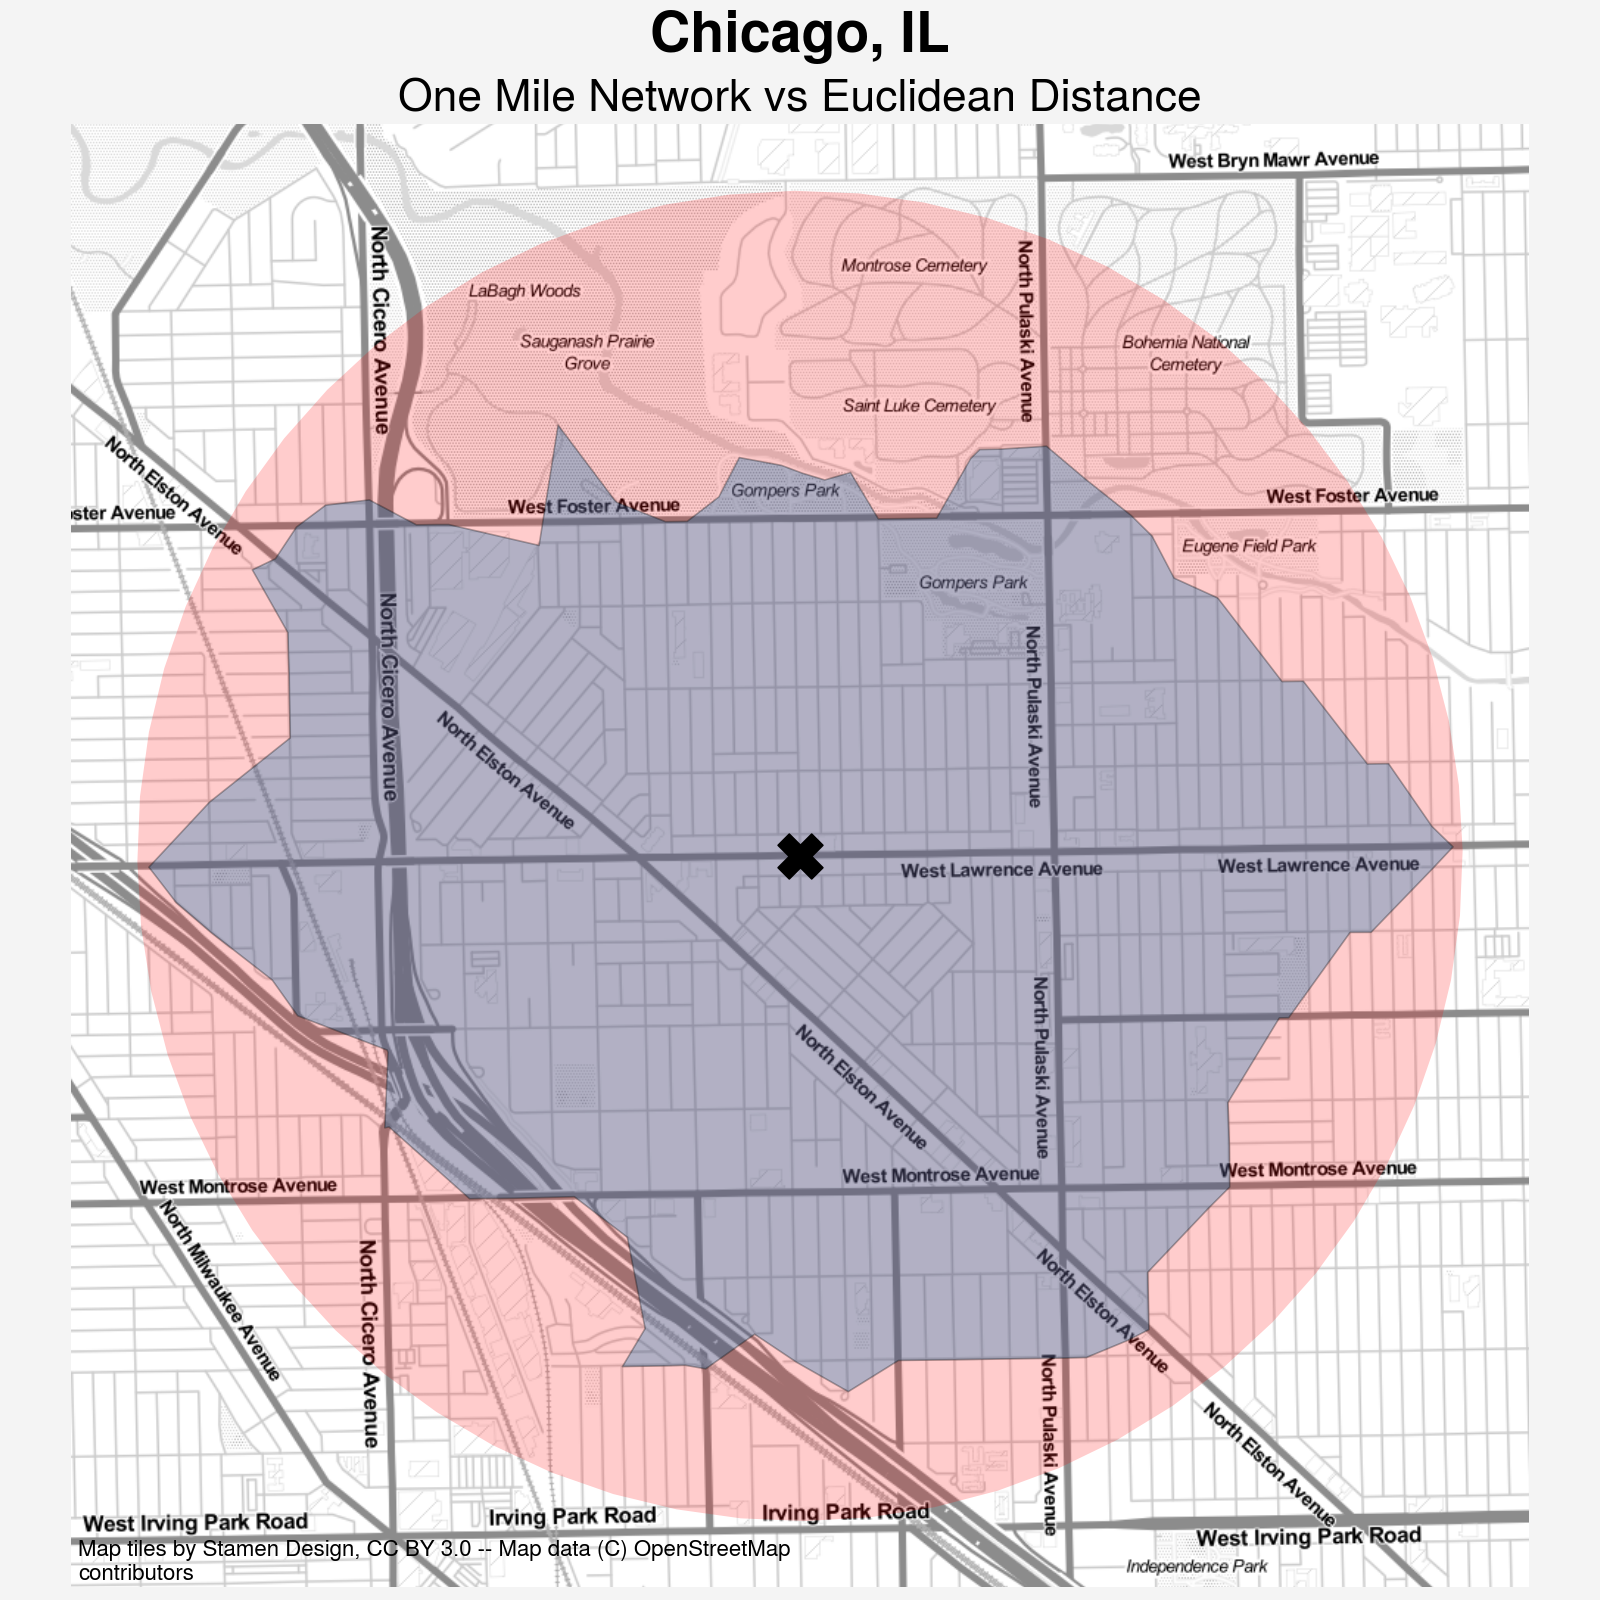

In [24]:
f, ax = pplt.subplots(figsize=(8,8))

chi_planar_iso.to_crs(3857).plot(ax=ax, color='red', alpha=0.2)
chi_iso.to_crs(3857).plot(ax=ax, alpha=0.3, ec='black', )
chi_point.to_crs(3857).plot(ax=ax, color='black', marker='X', markersize=260)
ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite)
ax.axis('off')
plt.suptitle('Chicago, IL', fontsize=20)
ax.set_title('One Mile Network vs Euclidean Distance', fontsize=16)
plt.savefig("../paper/figures/network_distance_chi.png", dpi=200)